In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Model

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive/MachineLearning/dog_cat_horse
# cd /content/drive/MyDrive/MachineLearning/ship

In [4]:
# os.getcwd()

# 10.1 Preprocessing, Load Base Model and Add New Layers

In [5]:
# Load base model
base_model = MobileNet(weights='imagenet', include_top=False) # include neural network out, get only cnn layers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) # you decide (if more, has more feature)
x = Dense(1024, activation='relu')(x) # ReLU rectified linear activation function
x = Dense(512, activation='relu')(x) # decide behavior of output form
preds = Dense(3, activation='softmax')(x) # prob of 1.00 of every class like (0.75, 0.12, 0.13)

In [7]:
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

In [8]:
print(len(model.layers))  # 91 layers
for layer in model.layers[:20]:  # train after 20 layers
    layer.trainable = False
for layer in model.layers[20:]:
    layer.trainable = True

91


# 10.2 Data Prepare / Augmentation

In [9]:
# increase dataset image
datagen = ImageDataGenerator(rescale=1./255,  # norm
                             rotation_range=30, zoom_range=0.5,
                             width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.15, horizontal_flip=True,
                             # preprocessing_function=preprocess_input,
                             fill_mode="nearest")

In [10]:
train_generator = datagen.flow_from_directory('./dog_cat_horse/train', # this is where you specify the path to the main data folder
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=16,
                                              class_mode='categorical', seed=0,
                                              shuffle=True)


Found 175 images belonging to 3 classes.


In [11]:
val_generator = datagen.flow_from_directory('./dog_cat_horse/validate/',  
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            batch_size=16,
                                            class_mode='categorical',
                                            seed=0,
                                            shuffle=True)


Found 31 images belonging to 3 classes.


[[[0.2660562  0.21115427 0.19938956]
  [0.2521596  0.19725762 0.18549292]
  [0.22235379 0.16745181 0.15568711]
  ...
  [0.02352941 0.0509804  0.1137255 ]
  [0.02352941 0.0509804  0.1137255 ]
  [0.02352941 0.0509804  0.1137255 ]]

 [[0.266863   0.21196102 0.20019631]
  [0.25525996 0.200358   0.1885933 ]
  [0.22269826 0.16779628 0.15603158]
  ...
  [0.02352941 0.0509804  0.1137255 ]
  [0.02352941 0.0509804  0.1137255 ]
  [0.02352941 0.0509804  0.1137255 ]]

 [[0.2685854  0.21368346 0.20191875]
  [0.25836036 0.2034584  0.1916937 ]
  [0.22304274 0.16814078 0.15637608]
  ...
  [0.02352941 0.0509804  0.1137255 ]
  [0.02352941 0.0509804  0.1137255 ]
  [0.02352941 0.0509804  0.1137255 ]]

 ...

 [[0.6429911  0.6154526  0.5474321 ]
  [0.62018734 0.5774107  0.51277757]
  [0.60682154 0.5562874  0.4935423 ]
  ...
  [0.77134997 0.8066441  0.8419382 ]
  [0.77184105 0.80713516 0.8424293 ]
  [0.7723322  0.8076263  0.8429204 ]]

 [[0.6360972  0.6041694  0.5337589 ]
  [0.60233414 0.56026846 0.49393487]


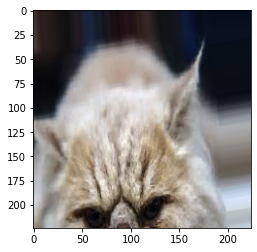

In [12]:
batch = train_generator.next()
img_train = batch[0] # * 255, imshow will convert to 255
print(img_train[0]) # the result continue to be a norm
plt.imshow(img_train[0])

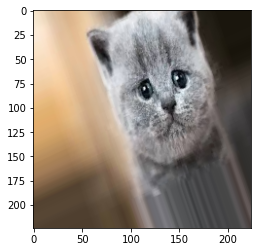

In [13]:
batch = val_generator.next()
img_train = batch[0] # * 255, imshow will convert to 255
plt.imshow(img_train[0])

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
epochs = 64
step_size_train = train_generator.n//train_generator.batch_size # round to int
step_size_val = val_generator.n//val_generator.batch_size # round to int
print(step_size_train, step_size_val)

10 1


In [16]:
import tensorflow as tf
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= "./temp/checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_size_train,
                              validation_data=val_generator,
                              validation_steps=step_size_val,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[model_checkpoint_callback])
                              
model.load_weights("./temp/checkpoint")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12264\3192844122.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/64
10/10 [==============================] - 13s 428ms/step - loss: 1.2918 - accuracy: 0.6289 - val_loss: 0.4648 - val_accuracy: 0.8125
Epoch 2/64
10/10 [==============================] - 3s 256ms/step - loss: 0.4681 - accuracy: 0.8428 - val_loss: 6.9247 - val_accuracy: 0.3750
Epoch 3/64
10/10 [==============================] - 2s 228ms/step - loss: 0.4809 - accuracy: 0.8428 - val_loss: 6.7761 - val_accuracy: 0.5000
Epoch 4/64
10/10 [==============================] - 2s 224ms/step - loss: 0.4436 - accuracy: 0.8805 - val_loss: 13.0918 - val_accuracy: 0.3125
Epoch 5/64
10/10 [==============================] - 2s 236ms/step - loss: 0.3316 - accuracy: 0.8868 - val_loss: 19.5678 - val_accuracy: 0.3125
Epoch 6/64
10/10 [==============================] - 3s 248ms/step - loss: 0.3527 - accuracy: 0.8994 - val_loss: 5.0676 - val_accuracy: 0.3750
Epoch 7/64
10/10 [==============================] - 2s 211ms/step - loss: 0.1850 - accuracy: 0.9371 - val_loss: 7.4409 - val_accuracy: 0.3750
Epo

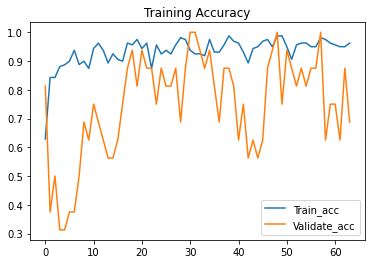

In [18]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train_acc")
plt.plot(history.history["val_accuracy"], label="Validate_acc")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

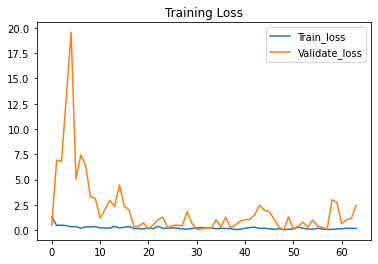

In [20]:
plt.figure()
plt.plot(history.history['loss'], label="Train_loss")
plt.plot(history.history['val_loss'], label="Validate_loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Testing

In [21]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                                                  './dog_cat_horse/test',
                                                  class_mode="categorical",
                                                  target_size=(224, 224), color_mode="rgb",
                                                  shuffle=False, seed=42,
                                                  batch_size=1)

Found 16 images belonging to 3 classes.


In [22]:
y_true = test_generator.classes

In [23]:
test_generator.reset()
pred_prob = []
for i in range(len(y_true)):
   pred=model.predict_generator(test_generator.next()[0])
   pred_prob.append(np.array(pred[0]))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12264\1348932972.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator.next()[0])


In [24]:
import pandas as pd

np.argmax(pred_prob, axis=1)
df_pred  = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)

In [25]:
df_pred

,0,1,2
0,0.000474,0.999521,0.000006
1,0.998791,0.001023,0.000186
2,0.984436,0.008794,0.006771
3,0.998793,0.000925,0.000281
4,0.684696,0.153873,0.161431
5,0.001085,0.998584,0.000331
6,0.044882,0.942666,0.012451
7,0.018234,0.961865,0.019900
8,0.527300,0.317408,0.155292
9,0.101460,0.482821,0.415720


In [26]:
df_class

0     1
1     0
2     0
3     0
4     0
5     1
6     1
7     1
8     0
9     1
10    1
11    2
12    2
13    2
14    2
15    2
dtype: int64

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [28]:
confusion_matrix(y_true, df_class)

array([[4, 1, 0],
       [1, 5, 0],
       [0, 0, 5]], dtype=int64)

In [29]:
print(classification_report(y_true, df_class))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.83      0.83      0.83         6
           2       1.00      1.00      1.00         5

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16



In [30]:
accuracy_score(y_true, df_class)

0.875